In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import random
import datetime

import numpy as np
import folium
import pandas as pd
import xarray as xr
from folium import plugins
from ocean_navigation_simulator.env.data_sources.DrifterData import DrifterData
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import lux
import os

dataset_drifter = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_GLO_UV_NRT_OBSERVATIONS_013_048',#name of the In Situ Near Real Time product in the GLO area
    'name': 'drifter',# name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_latest.txt', 'index_monthly.txt', 'index_history.txt'], #files describing the content of the lastest, monthly and history netCDF file collections available withint he above dataset
    'index_platform': 'index_platform.txt', #files describing the network of platforms contributing with files in the above collections
}
dataset_argo = {
    'host': 'nrt.cmems-du.eu',#ftp host => nrt.cmems-du.eu for Near Real Time products
    'product': 'INSITU_GLO_UV_NRT_OBSERVATIONS_013_048',#name of the In Situ Near Real Time product in the GLO area
    'name': 'argo',# name of the dataset available in the above In Situ Near Real Time product
    'index_files': ['index_history.txt'], #files describing the content of the lastest, monthly and history netCDF file collections available withint he above dataset
}

# define initial area of interest in order to increase speed
targeted_geospatial_lat_min = 25.0  # enter min latitude of your bounding box
targeted_geospatial_lat_max = 30.0  # enter max latitude of your bounding box
targeted_geospatial_lon_min = -120.0 # enter min longitude of your bounding box
targeted_geospatial_lon_max = -130.0 # enter max longitude of your bounding box
targeted_bbox = [targeted_geospatial_lon_min, targeted_geospatial_lat_min, targeted_geospatial_lon_max, targeted_geospatial_lat_max]  # (minx [lon], miny [lat], maxx [lon], maxy [lat])

# define intial time range of interest
targeted_time_range = '2021-01-01T00:00:00Z/2021-01-31T23:59:59Z'

config = {
    'data_dir': '/home/jonas/Documents/Thesis/OceanPlatformControl/data',
    'dataset': dataset_drifter,
    'targeted_bbox': targeted_bbox,
    'area_overlap_type': 'intersects',
    'targeted_time_range': targeted_time_range,
    'usr': "mmariuswiggert",
    "pas": "tamku3-qetroR-guwneq"
}

In [35]:
# Vis location of bbox
x_loc = (targeted_bbox[0]+ targeted_bbox[2])/2
y_loc = (targeted_bbox[1]+ targeted_bbox[3])/2
f = folium.Figure(width=500, height=500)
m = folium.Map(location=[y_loc, x_loc], zoom_start=4).add_to(f)
points = [(targeted_bbox[1], targeted_bbox[0]), (targeted_bbox[3], targeted_bbox[2])]
folium.Rectangle(bounds=points, color='#ff7800').add_to(m)
f

In [37]:
# download and load index files
drifter_data = DrifterData(config, read_only=False)
info = drifter_data.index_data
info.transpose()

...Downloading index_latest.txt
...Downloading index_monthly.txt
...Downloading index_history.txt
...Downloading index_platform.txt
...Loading info from: index_platform.txt
...Loading info from: index_latest.txt
...Loading info from: index_monthly.txt
...Loading info from: index_history.txt


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [38]:
# save pd for faster testing
path = os.path.join(config["data_dir"], "drifter_data", "index_data.csv")
info.to_csv(path)

In [34]:
# read in csv
path = os.path.join(config["data_dir"], "drifter_data", "index_data.csv")
info = pd.read_csv(path)
nc_links = info["file_name"].tolist()
info.shape

(59, 24)

In [41]:
# download all relevant files
nc_links = info["file_name"].tolist()
for i, file_link in enumerate(nc_links):
    drifter_data.downloadNCFile(file_link)

### Create pandas dataframe from drifter data

In [35]:
# pre-processing to minimise file size
file_list = [os.path.join(config["data_dir"], "drifter_data", "nc_files", file_link.split('/')[-1]) for file_link in nc_links]
start_time = datetime.datetime(2021,1,1)
end_time = datetime.datetime(2021,2,1)

column_names = ["time", "lon", "lat", "u", "v", "buoy"]
df = pd.DataFrame(columns = column_names)

for file_path in file_list:
    ds = DrifterData.readNCFile(file_path)

    # select specific data
    time = ds["TIME"].values
    lon = ds["LONGITUDE"].values
    lat = ds["LATITUDE"].values
    u = ds["NSCT"].isel(DEPTH=-1).values
    v = ds["EWCT"].isel(DEPTH=-1).values
    buoy = [file_path.split("/")[-1].split(".")[0] for i in range(len(time))]
    df_temp = pd.DataFrame({"time":time, "lon":lon, "lat":lat, "u":u, "v":v, "buoy":buoy})

    # filtering conditions
    lon_cond = ((df_temp["lon"] <= targeted_bbox[0]) & (df_temp["lon"] >= targeted_bbox[2]))
    lat_cond = ((df_temp["lat"] >= targeted_bbox[1]) & (df_temp["lat"] <= targeted_bbox[3]))
    time_cond = ((df_temp["time"] >= start_time) & (df_temp["time"] <= end_time))

    # filtering and concat to df
    df_temp = df_temp.loc[(lon_cond & lat_cond & time_cond)]
    df = pd.concat([df, df_temp])

    # change time column to datetime
    df["time"] = pd.to_datetime(df["time"])

# writing df to file
df.to_csv(os.path.join(config["data_dir"], "drifter_data", "drifter_data_2021_01.csv"), index=False)
print(df.shape)

(2569, 6)


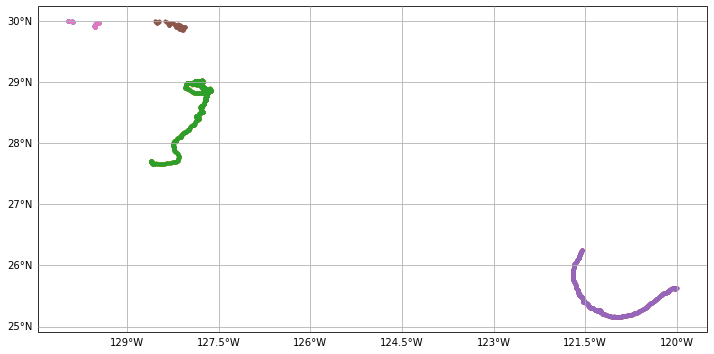

In [43]:
# setting up fig
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

for buoy_name in set(df["buoy"]):
    ax.scatter(df[df["buoy"] == buoy_name]["lon"], df[df["buoy"] == buoy_name]["lat"], marker=".")

### Get hincasts from opendap

In [6]:
from ocean_navigation_simulator.env.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.env.utils import units

# Create the source dict for the ocean currents
source_dict = {'field': 'OceanCurrents'}
source_dict['source'] = 'opendap'
source_dict['source_settings'] = {
                   'service': 'copernicus',
                   'currents': 'total', # if we want to take the normal uo, vo currents or 'total' for tide, normal added
                   'USERNAME': 'jdieker', 'PASSWORD': 'AxxzVqCuC#!vS69',
                   # 'DATASET_ID': 'global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh',
                   'DATASET_ID': 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'}

# What is this needed for?
sim_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 1}

In [7]:
# Create the ocean Field
ocean_field = OceanCurrentField(hindcast_source_dict=source_dict, sim_cache_dict=sim_cache_dict)

t_0 = datetime.datetime(2021, 1, 1, 1, 0, tzinfo=datetime.timezone.utc)
t_interval = [t_0, t_0 + datetime.timedelta(days=30)]
x_interval=[config["targeted_bbox"][2], config["targeted_bbox"][0]]
y_interval=[config["targeted_bbox"][1], config["targeted_bbox"][3]]

In [175]:
# instantiate object
ds_hind = ocean_field.hindcast_data_source.get_data_over_area(x_interval, y_interval, t_interval)

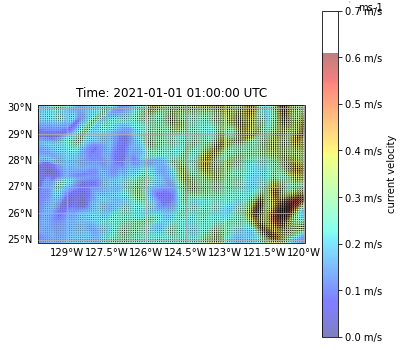

In [7]:
# plot retrieved data
ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=t_0, x_interval=x_interval, y_interval=y_interval,
    plot_type='quiver', return_ax=False)

### Casadi based Interpolation

In [8]:
from ocean_navigation_simulator.env.PlatformState import PlatformState
from ocean_navigation_simulator.env.utils import units
platform_state = PlatformState(lon=units.Distance(deg=np.mean(x_interval)), lat=units.Distance(deg=np.mean(y_interval)), date_time=t_0)
ocean_field.hindcast_data_source.update_casadi_dynamics(state=platform_state)

# convert buoy time axis to posix
df["time"] = pd.to_datetime(df["time"])
posix_timestamp = units.get_posix_time_from_np64(df["time"].values)
df["time_posix"] = posix_timestamp

HTTPError: Timeout

In [183]:
spatio_temporal_points = np.array([df["time_posix"], df["lat"], df["lon"]]).T

import casadi as ca

for i in range(spatio_temporal_points[:10].shape[0]):
    print(f"spatio-temporal point: {spatio_temporal_points[i]}")
    interp_point_u = ocean_field.hindcast_data_source.u_curr_func(spatio_temporal_points[i])
    print(f"interpolated value: {interp_point_u}")

spatio-temporal point: [ 1.6117164e+09  3.0000000e+01 -1.2854200e+02]
interpolated value: 215.3
spatio-temporal point: [ 1.61172e+09  2.99950e+01 -1.28535e+02]
interpolated value: 214.051
spatio-temporal point: [ 1.6117236e+09  2.9989000e+01 -1.2852900e+02]
interpolated value: 212.778
spatio-temporal point: [ 1.6117272e+09  2.9986000e+01 -1.2852600e+02]
interpolated value: 212.321
spatio-temporal point: [ 1.6117308e+09  2.9983000e+01 -1.2852200e+02]
interpolated value: 211.739
spatio-temporal point: [ 1.6117344e+09  2.9980000e+01 -1.2851800e+02]
interpolated value: 211.156
spatio-temporal point: [ 1.611738e+09  2.997600e+01 -1.285140e+02]
interpolated value: 210.424
spatio-temporal point: [ 1.6117416e+09  2.9974000e+01 -1.2851100e+02]
interpolated value: 210.111
spatio-temporal point: [ 1.6117452e+09  2.9975000e+01 -1.2850900e+02]
interpolated value: 210.363
spatio-temporal point: [ 1.6117488e+09  2.9975000e+01 -1.2850700e+02]
interpolated value: 210.466


### Multi-dimensional interpolation

In [12]:
def interp_hindcast(df, n=10):
    from tqdm import tqdm
    df["u_hind"] = 0
    df["v_hind"] = 0
    # convert time column to datetime
    df["time"] = pd.to_datetime(df["time"])

    for i in tqdm(range(0, df.shape[0], n)):
        # hindcast_interp = ds_hind.interp(time=df.iloc[i:i+n]["time"],
        #                                 lon=df.iloc[i:i+n]["lon"],
        #                                 lat=df.iloc[i:i+n]["lat"])
        hindcast_interp = ocean_field.hindcast_data_source.DataArray.interp(time=df.iloc[i:i+n]["time"],
                                                                            lon=df.iloc[i:i+n]["lon"],
                                                                            lat=df.iloc[i:i+n]["lat"])
        # add columns to dataframe
        df["u_hind"][i:i+n] = hindcast_interp["water_u"].values.diagonal().diagonal()
        df["v_hind"][i:i+n] = hindcast_interp["water_v"].values.diagonal().diagonal()
    return df

df = interp_hindcast(df)
# compute error columns
df["u_error"] = df["u_hind"] - df["u"]
df["v_error"] = df["v_hind"] - df["v"]

# # writing df to file
# df.to_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"), index=False)

In [106]:
df_nan = df[df["u_hind"].isna() == True]
df_nan.shape
# df_nan = interp_hindcast(df_nan, n=20)
# print(df_nan.isna().sum())
# df.shape

(117, 10)

In [33]:
# frames = [df, df_nan]
# df = pd.concat(frames)
# print(f"num of rows with nan values: {df.isna().sum()}")

### Scipy based Interpolation

In [ ]:
# from ocean_navigation_simulator.env.utils.units import get_posix_time_from_np64
# from scipy.interpolate import RegularGridInterpolator
# from tqdm import tqdm

# # need to convert time to posix time
# # ds = ocean_field.hindcast_data_source.DataArray
# ds = ds_hind
# posix_timestamp = [get_posix_time_from_np64(time) for time in ds["time"].values]
# ds = ds.assign_coords(time_posix=posix_timestamp)

# # define interpolation function (using hindcast coordinates and u,v)
# interp_u = RegularGridInterpolator((ds["time_posix"].values, ds["lat"].values, ds["lon"].values), ds["water_u"].values)
# # interp_v = RegularGridInterpolator((ds["time_posix"].values, ds["lat"].values, ds["lon"].values), ds["water_v"].values)

# # convert buoy time axis to posix
# df["time"] = pd.to_datetime(df["time"])
# posix_timestamp = [get_posix_time_from_np64(time) for time in df["time"].values]
# df["time_posix"] = posix_timestamp
# df["time_posix"]

# # Define points to interpolate
# points = np.array([df["time_posix"], df["lat"], df["lon"]]).T
# df["u_hind"] = 0
# df["v_hind"] = 0

# # split points into chunks
# n = 2
# for i in tqdm(range(100, points.shape[0], n)):
#     print(points[i:i+n].shape)
#     u_points = interp_u(points[i:i+n])
#     # v_points = interp_v(points[i:i+n])
#     print(u_points)
    
#     # add columns to dataframe
#     df["u_hind"][i:i+n] = u_points
#     # df["v_hind"][i:i+n] = v_points
#     break



HTTPError: 401 Unauthorized








<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
	<head>
	    <title>Login</title>
		<link href="http://marine.copernicus.eu/favicon.ico" rel="shortcut icon" type="image/x-icon" />
		<!-- link rel="icon" type="image/png" href="http://myo-wp.techworks.ie/devel/templates/myocean/favicon.png" /-->>
	    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />


		
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content.css" media="all" />
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content_cc.css" media="all" />
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/patch_content_cc.css" media="all" />
		<link rel="stylesheet" type="text/css" href="/cas/newCss/css/cssmanager.php?version=4.0.2-1288885946&amp;files=/cas/newCss/css/myocean/print/print_003.css" media="print" />
		
	    <!--[if gte IE 6]><style type="text/css" media="screen">@import 'css/ie_cas.css';</style><![endif]-->
	    <script type="text/javascript" src="js/common_rosters.js"></script>
		<style type="text/css">
input.submit{cursor:pointer}
</style>
	</head>
	
	<body id="cas"  class="claro" onload="init();" >

	
	
		<div id="white_background_inner_page" style="height:105px;"></div>
		<div id="col3_content" class="clearfix">
		

			<img src="/css/myocean/print/images/logo_myocean_print.png" width="1" height="1" align="left" id="logoPrint" alt="" />
			<div id="breadcrumb">
				<a href="http://marine.copernicus.eu/">Home</a> &gt; Login
			</div>

			
			
			<h1>Welcome to the CMEMS Data Access Portal</h1>
			<br/>
			<p>Fill your login/password and click on <strong>Login</strong> to download data. If you are not registred yet click on <a href="http://marine.copernicus.eu/web/56-user-registration-form.php" target="_parent">Register</a></p>
            <p>If you have trouble logging in, make sure your browser is set to accept cookies.</p>
            <br/>
	
	
	
	
			<form id="authentification" name="com-login" class="fm-v clearfix" action="/cas/login?service=http://localhost:8080/thredds/dodsC/cmems_mod_glo_phy_anfc_merged-uv_PT1H-i.dods?utotal.utotal%5B8784:1:9505%5D%5B0:1:0%5D%5B1259:1:1321%5D%5B599:1:720%5D" method="post">

			    
					<fieldset class="input">
					
						<label for="username">Username</label>
						<input id="username" name="username" class="required" tabindex="1" accesskey="i" type="text" value="" size="25" autocomplete="false"/><br />
						
						<label for="password">Password</label>
						<input id="password" name="password" class="required" tabindex="2" accesskey="m" type="password" value="" size="25" autocomplete="off"/><br />

						<input type="hidden" name="lt" value="_c550D6FE7-7E05-311D-B179-DE2D272B0DD5_k32D57D0D-2000-DEF5-C20D-E6ACD26B6494" />
						<input type="hidden" name="_eventId" value="submit" />
                      
						<div class="authentification_retrait_right">
							<a href="http://marine.copernicus.eu/web/56-user-registration-form.php" target="_parent"><img src="/cas/newCss/css/myocean/screen/images/bt_register.gif" alt="Register" /></a>
							<input class="submit" name="submit" accesskey="l" value=" " type="submit" alt="Login" />
						</div>

					</fieldset>
               
	            <p>
					<br/><br/>
					<i>- You are registered but have forgotten your login/password?</i><br/>
					<i>- Any question?</i><br/>
					<b>&rArr; CMEMS Service Desk : </b><A HREF="mailto:servicedesk.cmems@mercator-ocean.eu"><b>servicedesk.cmems@mercator-ocean.eu</b></A>
				</p>

			</form>	
				
				<h3>Thank you for using CMEMS products</h3>
				<br/>
	            <div id="sidebar">
	                <i>For security reasons, please Exit your web browser when you quit services requiring authentication!</i>
	            </div>
        	
		</div>
	    
	</body>
</html>



In [71]:
from scipy.interpolate import RegularGridInterpolator
def f(x,y,z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))

In [72]:
my_interpolating_function = RegularGridInterpolator((x, y, z), data)
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
print(pts.shape)
my_interpolating_function(pts)

(2, 3)


array([125.80469388, 146.30069388])

### Save Interpolated Data

In [39]:
df.to_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"), index=False)

In [10]:
# load previous csv
df = pd.read_csv(os.path.join(config["data_dir"], "drifter_data", "current_error_2021_01.csv"))
print(f"count NaN rows: {df['u_hind'].isna().sum()}")

count NaN rows: 117


### Plot Mean and RMSE

In [11]:
# RMSE
def calc_speed_RMSE(u_data_hindcast, v_data_hindcast, u_data_measured, v_data_measured):
    RMSE_speed = np.sqrt((u_data_hindcast-u_data_measured)**2 + (v_data_hindcast-v_data_measured)**2)
    return RMSE_speed

df["RMSE_speed"] = calc_speed_RMSE(df["u_hind"], df["v_hind"], df["u"], df["v"])

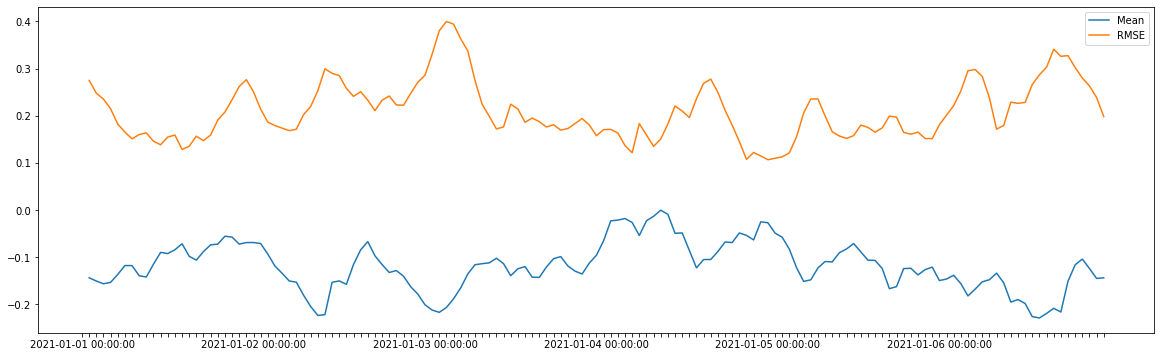

In [12]:
# mean current error vs time
df_filt = df[df["time"] < "2021-01-07"]
df_filt_group = df_filt.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
plt.locator_params(axis='x', nbins=7)
plt.plot(df_filt_group["time"], (df_filt_group["u_error"]*np.cos(np.pi/4) + df_filt_group["v_error"]*np.cos(np.pi/4)), label="Mean")
plt.plot(df_filt_group["time"], df_filt_group["RMSE_speed"], label="RMSE")
plt.legend()

# needed to supress most labels
every_nth = 24
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

In [11]:
def calc_vector_correlation(u_data_hindcast, v_data_hindcast, u_data_measured, v_data_measured, print_out=False):
    """
    Calculates the vector correlation for one buoy for a specific day,
    where one day typically has 24 measurements.
    """

    # Flatten out the vectors
    # first Stack them
    hindcast = np.stack((u_data_hindcast, v_data_hindcast))
    measured = np.stack((u_data_measured, v_data_measured))
    hindcast_vec = hindcast.reshape(2, -1)
    measured_vec = measured.reshape(2, -1)
    # Step 1: calculate the correlation matrix
    full_variable_vec = np.vstack((measured_vec, hindcast_vec))
    Covariance_matrix = np.cov(full_variable_vec)
    # calculation for vector correlation
    Sigma_11 = Covariance_matrix[:2,:2]
    Sigma_22 = Covariance_matrix[2:,2:]
    Sigma_12 = Covariance_matrix[:2,2:]
    Sigma_21 = Covariance_matrix[2:,:2]
    # Matrix multiplications
    epsilon = 0
    vector_correlation = np.trace(np.linalg.inv(Sigma_11) @ Sigma_12 @ np.linalg.inv(Sigma_22) @ Sigma_21)
    while np.isnan(vector_correlation):
        epsilon += 5e-5
        vector_correlation = np.trace(np.linalg.inv(Sigma_11 + epsilon*np.eye(2)) @ Sigma_12 @ np.linalg.inv(Sigma_22 + epsilon*np.eye(2)) @ Sigma_21)
        if epsilon > 1e-1:
            break
    return vector_correlation

def get_vector_correlation_per_day(df_day):
    """
    Calculates the vector correlation per day per buoy and takes the average for that day

    Expects a dataframe with data from one or more buoys over one day
    """
    buoy_names = set(df_day["buoy"].tolist())
    vec_corr_total = 0
    for name in buoy_names:
        points_buoy = df_day[df_day["buoy"] == name]
        vec_corr = calc_vector_correlation(points_buoy["u_hind"],
                                                points_buoy["v_hind"],
                                                points_buoy["u"],
                                                points_buoy["v"])
        if np.isnan(vec_corr):
            vec_corr = 0
        vec_corr_total += vec_corr
    if len(buoy_names) != 0:
        return vec_corr_total/len(buoy_names)
    return -1

def get_vector_correlation_over_time(df):
    """
    Gets the vector correlation over the entire time range covered in the dataframe
    """
    df["day"] = df["time"].apply(lambda x: x[:10])
    days = sorted(set(df["day"].tolist()))
    vec_corr = []
    for day in days:
        df_day = df[df["day"] == day]
        vec_corr.append(get_vector_correlation_per_day(df_day))
    df_vec_corr = pd.DataFrame({"day": days, "vec_corr": vec_corr})
    return df_vec_corr


df["day"] = df["time"].apply(lambda x: x[:10])
df_vec_corr = get_vector_correlation_over_time(df[df["day"] == df["day"].tolist()[0]])

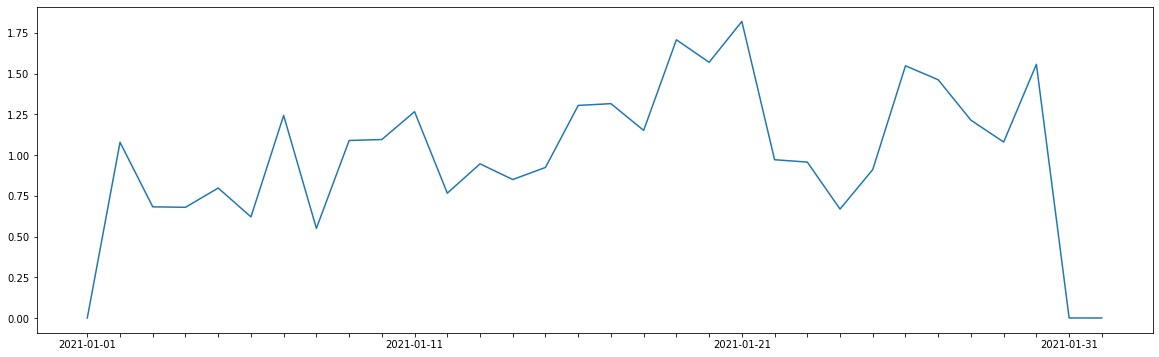

In [15]:
# plotting vector correlation (where the plot is zero no or only one buoy provided a measurement)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df_vec_corr["day"], df_vec_corr["vec_corr"], label="Vector Correlation")

# needed to supress most labels
every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

### Plot Spatial Error

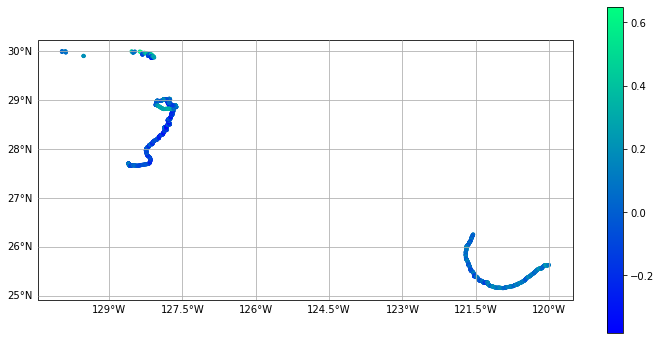

In [105]:
# spatial plot of error
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

plt.scatter(df["lon"], df["lat"], c=df["u_error"], marker=".", cmap="winter")
plt.colorbar()
plt.show()

Plot above is for an area of 500 km by 984 km